#  <center> Speech Emotion Recognition <center>

### Em sẽ xây dựng 1 mô hình nhận diện cảm xúc trong 1 đoạn âm thanh

#### Tập dữ liệu được sử dụng để xây dựng và huấn luyện mô hình:

* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)
* Toronto emotional speech set (Tess)
* Surrey Audio-Visual Expressed Emotion (Savee)


# Chuẩn bị các thư viện

In [ ]:
import pandas as pd
import numpy as np

import os
import sys


import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


from IPython.display import Audio

import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Chuẩn bị dữ liệu
* Em sẽ xây dựng bộ dữ liệu dựa trên 4 tập dữ liệu khác nhau nên sẽ dùng DataFrame để lưu các nhãn cảm xúc và đường dẫn đến file âm thanh


In [ ]:
# Kết nối với dữ liệu từ google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths for data.
ravdess = "../content/drive/MyDrive/input/ravdess/audio_speech_actors_01-24/"
cremad = "../content/drive/MyDrive/input/cremad/AudioWAV/"
tess = "../content/drive/MyDrive/input/tess/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/"
savee = "../content/drive/MyDrive/input/savee/ALL/"

## Tập dữ liệu Ravdess
Các xác định các thành phần từ tên File của tập dữ liệu Ravdess

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


In [ ]:
ravdess_directory_list = os.listdir(ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(ravdess + dir)
    for file in actor:
        part = file.split('.')[0]   # Tách tên file khỏi .wav
        part = part.split('-')      # Tách các thành phần trong tên file
        file_emotion.append(int(part[2]))       # Thành phần cảm xúc
        file_path.append(ravdess + dir + '/' + file)
        
# Dataframe cho các file cảm xúc
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe cho đường dẫn các file
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.head()

,Emotions,Path
0,angry,../content/drive/MyDrive/input/ravdess/audio_s...
1,calm,../content/drive/MyDrive/input/ravdess/audio_s...
2,sad,../content/drive/MyDrive/input/ravdess/audio_s...
3,happy,../content/drive/MyDrive/input/ravdess/audio_s...
4,sad,../content/drive/MyDrive/input/ravdess/audio_s...


## Tập dữ liệu Crema-D

In [ ]:
crema_directory_list = os.listdir(cremad)

file_emotion = []
file_path = []

for file in crema_directory_list:
    file_path.append(cremad + file)
    part=file.split('_')                # Tách các thành phần trong tên file
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
cremad_df = pd.concat([emotion_df, path_df], axis=1)
cremad_df.head()

,Emotions,Path
0,disgust,../content/drive/MyDrive/input/cremad/AudioWAV...
1,sad,../content/drive/MyDrive/input/cremad/AudioWAV...
2,happy,../content/drive/MyDrive/input/cremad/AudioWAV...
3,sad,../content/drive/MyDrive/input/cremad/AudioWAV...
4,sad,../content/drive/MyDrive/input/cremad/AudioWAV...


## Tập dữ liệu TESS
Đối với tập dữ liệu TESS, nó chỉ dựa trên 2 diễn giả, một phụ nữ trẻ và một phụ nữ lớn tuổi. Điều này hy vọng sẽ cân bằng các diễn giả nam nổi trội mà chúng ta có trên SAVEE. Nó có cùng 7 cảm xúc chính mà chúng ta quan tâm.

In [ ]:
tess_directory_list = os.listdir(tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(tess + dir)
    for file in directories:
        part = file.split('.')[0]               # Tách tên file với .wav
        part = part.split('_')[2]               # Lấy thành phần cảm xúc
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(tess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
tess_df = pd.concat([emotion_df, path_df], axis=1)
tess_df.head()

,Emotions,Path
0,fear,../content/drive/MyDrive/input/tess/TESS Toron...
1,fear,../content/drive/MyDrive/input/tess/TESS Toron...
2,fear,../content/drive/MyDrive/input/tess/TESS Toron...
3,fear,../content/drive/MyDrive/input/tess/TESS Toron...
4,fear,../content/drive/MyDrive/input/tess/TESS Toron...


## Tập dữ liệu Savee
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [ ]:
savee_directory_list = os.listdir(savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(savee + file)
    part = file.split('_')[1]               
    ele = part[:-6]                     # Lấy thành phần cảm xúc
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
savee_df = pd.concat([emotion_df, path_df], axis=1)
savee_df.head()

,Emotions,Path
0,angry,../content/drive/MyDrive/input/savee/ALL/DC_a0...
1,angry,../content/drive/MyDrive/input/savee/ALL/DC_a1...
2,angry,../content/drive/MyDrive/input/savee/ALL/DC_a1...
3,angry,../content/drive/MyDrive/input/savee/ALL/DC_a1...
4,angry,../content/drive/MyDrive/input/savee/ALL/DC_a1...


In [ ]:
# Ghép thành bộ dữ liệu
data_path = pd.concat([ravdess_df, cremad_df, tess_df, savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,angry,../content/drive/MyDrive/input/ravdess/audio_s...
1,calm,../content/drive/MyDrive/input/ravdess/audio_s...
2,sad,../content/drive/MyDrive/input/ravdess/audio_s...
3,happy,../content/drive/MyDrive/input/ravdess/audio_s...
4,sad,../content/drive/MyDrive/input/ravdess/audio_s...


## Trực quan hóa dữ liệu

Đếm số lượng bản ghi của từng biểu cảm

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


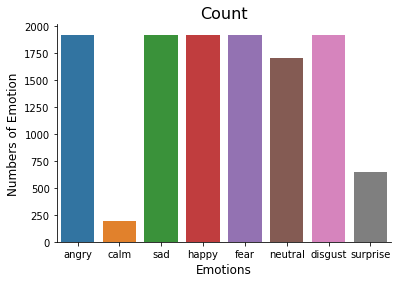

In [ ]:
plt.title('Count', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Numbers of Emotion', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Biểu diễn âm thanh bằng Waveplot và Spectrogram


In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

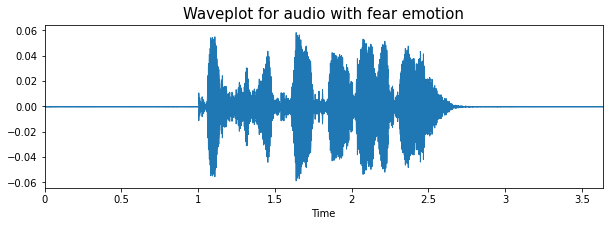

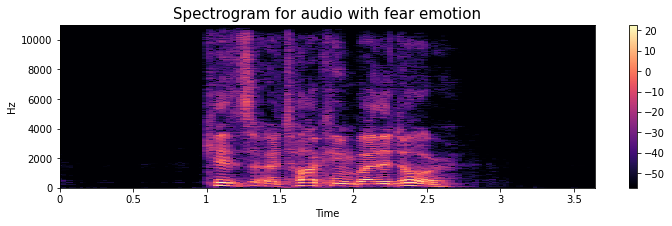

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Tăng dữ liệu

- Để tăng dữ liệu âm thanh, chúng ta có thể áp dụng chèn nhiễu, chuyển thời gian, thay đổi cao độ và tốc độ.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Âm thanh bình thường

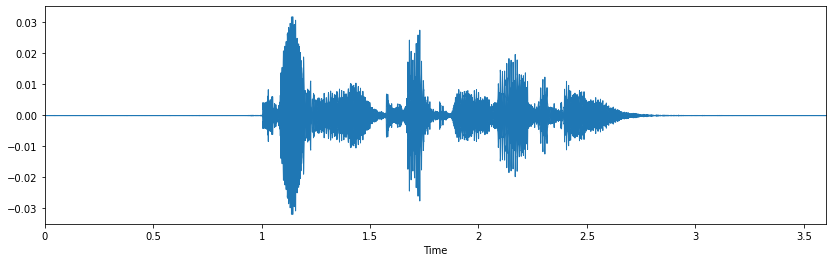

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

#### 2. Âm thanh khi bị chèn nhiễu

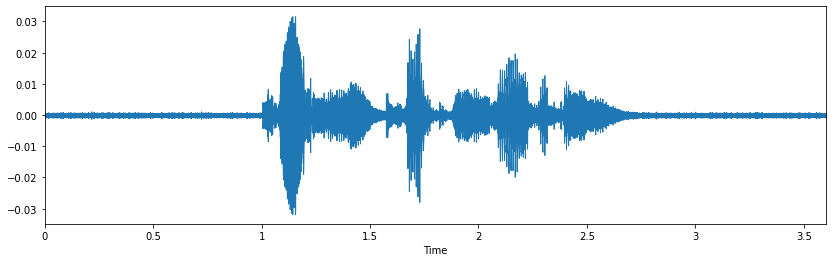

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Kéo dài thời gian mà không ảnh hưởng đến cao độ

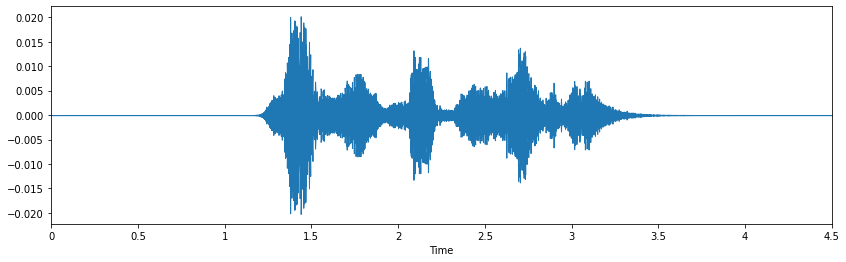

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

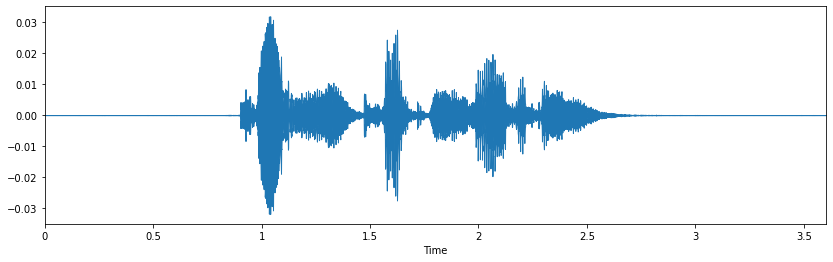

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Thay đổi cao độ mà không ảnh hưởng đến tốc độ

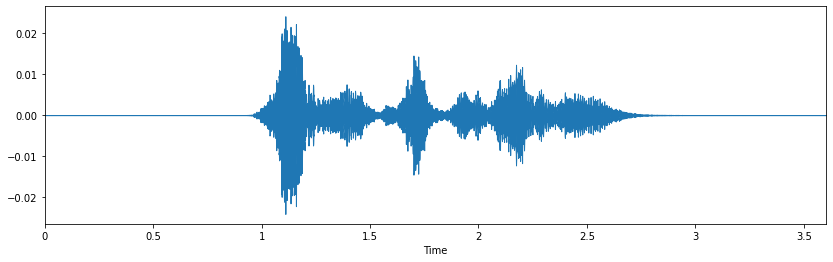

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Trích xuất đặc trưng

Trích xuất các đặc trưng sau của âm thanh:
- ZCR (Zero Crossing Rate)
- Chroma_stft
- MFCC
- Giá trị RMS(root mean square)
- MelSpectogram.

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Trích xuất đặc trưng âm thanh gốc
    res1 = extract_features(data)
    result = np.array(res1)
    
    # Trích xuất đặc trưng âm thanh bị chèn nhiễu
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # Trích xuất đặc trưng âm thanh bị kéo
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.305171,0.643884,0.656930,0.700355,0.714716,0.727979,0.712169,0.690421,0.661609,0.654287,...,0.000099,0.000103,0.000064,0.000083,0.000095,0.000099,0.000050,0.000011,6.133249e-07,calm
1,0.321791,0.708566,0.738636,0.797760,0.810628,0.842439,0.799675,0.724058,0.709639,0.687424,...,0.000298,0.000286,0.000259,0.000283,0.000293,0.000292,0.000246,0.000203,2.041790e-04,calm
2,0.152951,0.632365,0.602032,0.660238,0.680948,0.677680,0.701253,0.695028,0.672547,0.629242,...,0.000027,0.000018,0.000028,0.000019,0.000015,0.000018,0.000019,0.000006,2.763042e-07,calm
3,0.289081,0.680593,0.710745,0.767278,0.757717,0.704341,0.640463,0.605046,0.568435,0.564436,...,0.001407,0.001227,0.001499,0.001057,0.000663,0.000594,0.000767,0.000450,1.702770e-05,happy
4,0.298037,0.706432,0.742056,0.797776,0.768291,0.753911,0.657512,0.602639,0.590486,0.604448,...,0.001433,0.001254,0.001522,0.001074,0.000689,0.000618,0.000786,0.000465,3.305420e-05,happy


## Chuẩn bị dữ liệu huấn luyện

- Chuẩn hóa lại dữ liệu và chia tập train/test

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# Bài toán phân loại đa lớp -> Sử dụng mã hóa one-hot
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# Chia tập dữ liệu
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# Cân đói lại tập dữ liệu
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

## Modelling

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 17s 11ms/step - loss: 1.7295 - accuracy: 0.2956 - val_loss: 1.4749 - val_accuracy: 0.4182 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 4s 10ms/step - loss: 1.5070 - accuracy: 0.3948 - val_loss: 1.3650 - val_accuracy: 0.4476 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 4s 10ms/step - loss: 1.4117 - accuracy: 0.4351 - val_loss: 1.2910 - val_accuracy: 0.4921 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 4s 10ms/step - loss: 1.3490 - accuracy: 0.4605 - val_loss: 1.2201 - val_accuracy: 0.5128 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 4s 10ms/step - loss: 1.2951 - accuracy: 0.4837 - val_loss: 1.2002 - val_accuracy: 0.5240 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 4s 10ms/step - loss: 1.2628 - accuracy: 0.4937 - val_loss: 1.1698 - val_accuracy: 0.5327 - lr: 0.0010
Epoch 7/50
428/428 [==============================] - 4s 10ms/s

286/286 [==============================] - 1s 4ms/step - loss: 1.1370 - accuracy: 0.5938
Accuracy of our model on test data :  59.38390493392944 %


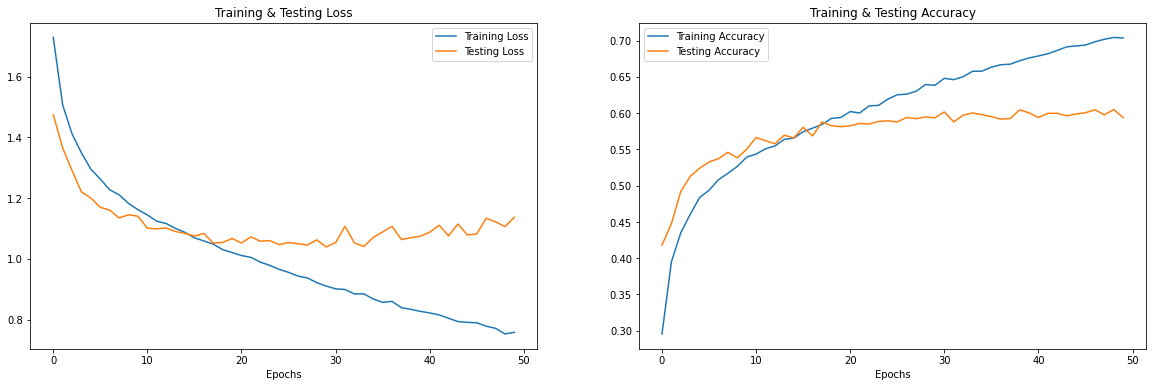

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# Dự đoán trên tập test.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,sad
1,surprise,surprise
2,fear,fear
3,sad,fear
4,disgust,disgust
5,fear,disgust
6,happy,happy
7,happy,happy
8,fear,sad
9,neutral,neutral


In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.74      0.70      0.72      1428
        calm       0.67      0.77      0.72       139
     disgust       0.47      0.55      0.51      1435
        fear       0.60      0.51      0.55      1489
       happy       0.55      0.52      0.53      1459
     neutral       0.54      0.57      0.55      1229
         sad       0.63      0.61      0.62      1456
    surprise       0.73      0.84      0.79       487

    accuracy                           0.59      9122
   macro avg       0.62      0.63      0.62      9122
weighted avg       0.60      0.59      0.59      9122



In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")

In [ ]:
# imports
from keras.models import model_from_json 

# opening and store file in a variable

json_file = open('model.json','r')
loaded_model_json = json_file.read()
json_file.close()

# use Keras model_from_json to make a loaded model

loaded_model = model_from_json(loaded_model_json)

# load weights into new model

loaded_model.load_weights("model.h5")
print("Loaded Model from disk")

# compile and evaluate loaded model

loaded_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])



Loaded Model from disk
